<a href="https://colab.research.google.com/github/5hyfilm/yslc2021-c08-jordan/blob/main/build_model_with_pipeline_yslc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake News Classification by JORDAN Team



Young Safe Internet Leader Camp (YSLC) Version 3.0 2021

# Install & Import Libraries

## Install

In [ ]:
!pip install pythainlp
!pip install emoji

     |████████████████████████████████| 11.0 MB 5.0 MB/s 
     |████████████████████████████████| 743 kB 46.8 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.7.4.3
    Uninstalling typing-extensions-3.7.4.3:
      Successfully uninstalled typing-extensions-3.7.4.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires typing-extensions~=3.7.4, but you have typing-extensions 3.10.0.0 which is incompatible.
     |████████████████████████████████| 184 kB 5.1 MB/s 
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186469 sha256=c83f31d3fa422dd02f90481eee646501a392f2effe040cbafd458ebebc2efe27
  Stored in directory: /root/.cache/pip/wheels/e4/61/e7/2fc1ac8f306848fc66c6c013ab511f0a39ef4b1825b11363b2
Successfully built emoji


## Import

In [ ]:
import pandas as pd
import pythainlp
import pythainlp.util
from pythainlp import sent_tokenize
from pythainlp import word_tokenize
from pythainlp.ulmfit import process_thai
import string
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
from matplotlib import pyplot as plt
import itertools

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Preview Data

In [ ]:
df = pd.read_csv('/content/yslc2021-data.csv')

In [ ]:
df.shape

(1700, 6)

In [ ]:
df.head()

,id,title,text,author,url,label
0,1,อย่าหลงเชื่อ ข่าวปลอม ยาพาราเซตามอลปนเปื้อนเชื...,เป็นกระแสดังมาก ถึงเรื่องการห้ามกินยาพาราเซตาม...,ข่าวประชาสัมพันธ์ กองพัฒนาศักยภาพผู้บริโภค,https://www.antifakenewscenter.com/ข่าวปลอม-ยา...,0
1,2,ข่าวปลอม “บิ๊กตู่” เรียกเก็บเงินภาษี 7 % “ก้าว...,หลังจากที่มีการนำเสนอข่าวรัฐบาลประชุมเรียกเก็บ...,http://www.mgronline.com/,https://www.antifakenewscenter.com/ข่าวปลอม-ก้...,0
2,3,เว็บคลิกเบทผุดข่าวปลอม เสี่ยตัน ไม่ช่วย พี่ตูน...,ทำไมเรายังแชร์ข่าวปลอม! ชาวเน็ตด่าขรม เว็บคลิก...,ไทยรัฐ ออนไลน์,https://www.antifakenewscenter.com/เว็บคลิกเบท...,0
3,4,สธ.เตือน “อย่าเชื่อ-อย่าแชร์” ข่าวปลอมอ้างมีคน...,กระทรวงสาธารณสุขแจ้งเตือนประชาชน “อย่าเชื่อ-อย...,http://www.posttoday.com/,https://www.antifakenewscenter.com/ข่าวปลอม-คน...,0
4,5,“ไอซ์ ปรีชญา” เดือด เว็บปลอมกุข่าว โดนรวบปาร์ต...,“ไอซ์ ปรีชญา พงษ์ธนานิกร” เดือด เว็ปปลอมกุข่าว...,http://www.brighttv.co.th/,https://www.antifakenewscenter.com/ไอซ์ปรีชญา-...,0


### Prevalence

In [ ]:
print(df["label"].value_counts() / df.shape[0])

0    0.840588
1    0.159412
Name: label, dtype: float64


# Preprocessing

## Clean Text by Remove Punctuation

In [ ]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
def remove_punctuation(txt):
  txt_nopunct = ''.join([c for c in str(txt) if c not in string.punctuation])
  return txt_nopunct

In [ ]:
df['text_clean'] = df['text'].apply(lambda x: remove_punctuation(x))

In [ ]:
df.head()

,id,title,text,author,url,label,text_clean
0,1,อย่าหลงเชื่อ ข่าวปลอม ยาพาราเซตามอลปนเปื้อนเชื...,เป็นกระแสดังมาก ถึงเรื่องการห้ามกินยาพาราเซตาม...,ข่าวประชาสัมพันธ์ กองพัฒนาศักยภาพผู้บริโภค,https://www.antifakenewscenter.com/ข่าวปลอม-ยา...,0,เป็นกระแสดังมาก ถึงเรื่องการห้ามกินยาพาราเซตาม...
1,2,ข่าวปลอม “บิ๊กตู่” เรียกเก็บเงินภาษี 7 % “ก้าว...,หลังจากที่มีการนำเสนอข่าวรัฐบาลประชุมเรียกเก็บ...,http://www.mgronline.com/,https://www.antifakenewscenter.com/ข่าวปลอม-ก้...,0,หลังจากที่มีการนำเสนอข่าวรัฐบาลประชุมเรียกเก็บ...
2,3,เว็บคลิกเบทผุดข่าวปลอม เสี่ยตัน ไม่ช่วย พี่ตูน...,ทำไมเรายังแชร์ข่าวปลอม! ชาวเน็ตด่าขรม เว็บคลิก...,ไทยรัฐ ออนไลน์,https://www.antifakenewscenter.com/เว็บคลิกเบท...,0,ทำไมเรายังแชร์ข่าวปลอม ชาวเน็ตด่าขรม เว็บคลิกเ...
3,4,สธ.เตือน “อย่าเชื่อ-อย่าแชร์” ข่าวปลอมอ้างมีคน...,กระทรวงสาธารณสุขแจ้งเตือนประชาชน “อย่าเชื่อ-อย...,http://www.posttoday.com/,https://www.antifakenewscenter.com/ข่าวปลอม-คน...,0,กระทรวงสาธารณสุขแจ้งเตือนประชาชน “อย่าเชื่ออย่...
4,5,“ไอซ์ ปรีชญา” เดือด เว็บปลอมกุข่าว โดนรวบปาร์ต...,“ไอซ์ ปรีชญา พงษ์ธนานิกร” เดือด เว็ปปลอมกุข่าว...,http://www.brighttv.co.th/,https://www.antifakenewscenter.com/ไอซ์ปรีชญา-...,0,“ไอซ์ ปรีชญา พงษ์ธนานิกร” เดือด เว็ปปลอมกุข่าว...


## Tokenization

In [ ]:
df["processed"] = df.text_clean.map(lambda x: "|".join(process_thai(x)))
df["wc"] = df.processed.map(lambda x: len(x.split("|")))
df["uwc"] = df.processed.map(lambda x: len(set(x.split("|"))))

# test_df["processed"] = test_df.texts.map(lambda x: "|".join(process_thai(x)))
# test_df["wc"] = test_df.processed.map(lambda x: len(x.split("|")))
# test_df["uwc"] = test_df.processed.map(lambda x: len(set(x.split("|"))))

In [ ]:
df.head()

,id,title,text,author,url,label,text_clean,processed,wc,uwc
0,1,อย่าหลงเชื่อ ข่าวปลอม ยาพาราเซตามอลปนเปื้อนเชื...,เป็นกระแสดังมาก ถึงเรื่องการห้ามกินยาพาราเซตาม...,ข่าวประชาสัมพันธ์ กองพัฒนาศักยภาพผู้บริโภค,https://www.antifakenewscenter.com/ข่าวปลอม-ยา...,0,เป็นกระแสดังมาก ถึงเรื่องการห้ามกินยาพาราเซตาม...,เป็น|กระแส|ดัง|มาก|ถึง|เรื่อง|การ|ห้าม|กิน|ยา|...,200,115
1,2,ข่าวปลอม “บิ๊กตู่” เรียกเก็บเงินภาษี 7 % “ก้าว...,หลังจากที่มีการนำเสนอข่าวรัฐบาลประชุมเรียกเก็บ...,http://www.mgronline.com/,https://www.antifakenewscenter.com/ข่าวปลอม-ก้...,0,หลังจากที่มีการนำเสนอข่าวรัฐบาลประชุมเรียกเก็บ...,หลังจากที่|มี|การ|นำเสนอ|ข่าว|รัฐบาล|ประชุม|เร...,265,141
2,3,เว็บคลิกเบทผุดข่าวปลอม เสี่ยตัน ไม่ช่วย พี่ตูน...,ทำไมเรายังแชร์ข่าวปลอม! ชาวเน็ตด่าขรม เว็บคลิก...,ไทยรัฐ ออนไลน์,https://www.antifakenewscenter.com/เว็บคลิกเบท...,0,ทำไมเรายังแชร์ข่าวปลอม ชาวเน็ตด่าขรม เว็บคลิกเ...,ทำไม|เรา|ยัง|แชร์|ข่าว|ปลอม|ชาว|เน็ต|ด่า|ขรม|เ...,169,102
3,4,สธ.เตือน “อย่าเชื่อ-อย่าแชร์” ข่าวปลอมอ้างมีคน...,กระทรวงสาธารณสุขแจ้งเตือนประชาชน “อย่าเชื่อ-อย...,http://www.posttoday.com/,https://www.antifakenewscenter.com/ข่าวปลอม-คน...,0,กระทรวงสาธารณสุขแจ้งเตือนประชาชน “อย่าเชื่ออย่...,กระทรวงสาธารณสุข|แจ้ง|เตือน|ประชาชน|“|อย่า|เชื...,110,71
4,5,“ไอซ์ ปรีชญา” เดือด เว็บปลอมกุข่าว โดนรวบปาร์ต...,“ไอซ์ ปรีชญา พงษ์ธนานิกร” เดือด เว็ปปลอมกุข่าว...,http://www.brighttv.co.th/,https://www.antifakenewscenter.com/ไอซ์ปรีชญา-...,0,“ไอซ์ ปรีชญา พงษ์ธนานิกร” เดือด เว็ปปลอมกุข่าว...,“|ไอ|ซ์|ปรีชญา|พง|ษ์ธ|นา|นิกร|”|เดือด|เว็ป|ปลอ...,336,182


## Split

In [ ]:
x = df['text_clean']
y = df['label']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=0)

In [ ]:
x_train.shape

(1360,)

### Features

In [ ]:
classifier = Pipeline([('tfidf', TfidfVectorizer(tokenizer=process_thai, ngram_range=(1,2), min_df=20, sublinear_tf=True)),
                    ('pacmodel', CalibratedClassifierCV(PassiveAggressiveClassifier(max_iter=50)))])

In [ ]:
classifier.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=20, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=True,
                                 token_pattern='...
                                 use_idf=True, vocabulary=None)),
                ('pacmodel',
                 CalibratedClassifierCV(base_estimator=PassiveAggressiveClassifier(C=1.0,
                                                                                   average=False,
                   

# Evaluation

### Label
*   0 = Fake News ข่าวปลอม
*   1 = Real News ข่าวจริง



In [ ]:
y_pred = classifier.predict(x_test)
score = accuracy_score(y_test, y_pred)
print(f'Accuracy: {round(score * 100, 2)}%')

Accuracy: 99.12%


## Confusion Matrix

In [ ]:
cf = confusion_matrix(y_test, y_pred, labels=[0, 1])
print(cf)

[[283   1]
 [  2  54]]


In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[283   1]
 [  2  54]]


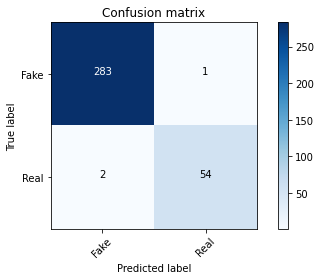

In [ ]:
plot_confusion_matrix(cf, ['Fake', 'Real'])

Normalized confusion matrix
[[0.99647887 0.00352113]
 [0.03571429 0.96428571]]


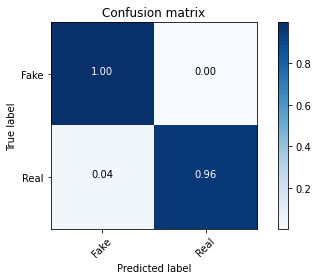

In [ ]:
plot_confusion_matrix(cf, ['Fake', 'Real'], normalize=True)

## Classification Report

In [ ]:
print(classification_report(y_test, y_pred, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       284
           1       0.98      0.96      0.97        56

    accuracy                           0.99       340
   macro avg       0.99      0.98      0.98       340
weighted avg       0.99      0.99      0.99       340



# Save Model

## Dump Model

In [ ]:
import pickle
with open('yslc-jordan-model.pickle', 'wb') as handle:
    pickle.dump(classifier, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('/content/yslc-jordan-model.pickle', 'rb') as handle:
	loaded_model = pickle.load(handle) 

# Prediction

In [ ]:
news = 'กรณี รถฟอร์จูนเนอร์ตกสะพานขาดที่ อ.นบพิตำ ช่วงน้ำท่วมใหญ่ปลายปี 63 ทำให้มีผู้เสียชีวิต 1 ศพ และรอดมาได้ 1 ราย ล่าสุด พบซากรถที่ถูกกระแสน้ำพัดห่างจากจุดเกิดเหตุไป 500 เมตร สภาพแหลกยับทั้งคัน'

## Class Prediction

In [ ]:
prediction = loaded_model.predict([news])

In [ ]:
print(prediction)

[1]


## Probability of Prediction

In [ ]:
prediction_proba = loaded_model.predict_proba([news])

In [ ]:
prediction_proba_2f = max(max(prediction_proba))*100

In [ ]:
print(prediction_proba_2f)

63.133001234726706


# Download Model

In [ ]:
from google.colab import files
files.download('/content/yslc-jordan-model.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>